In [1]:
import json
import os
import argparse
import sys

import torch
from torch import nn, optim
from torch.nn import functional as F
from speaker_encoder import LSTM_Classification as model

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(""))))
import commons
import utils
from utils import load_filepaths_and_text, load_wav_to_torch

In [2]:
def audio_processing(audio_path, hps):
    audio, sr = load_wav_to_torch(audio_path)
    audio_norm = audio/ hps.data.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    stft = commons.TacotronSTFT(hps.data.filter_length, hps.data.hop_length, 
                               hps.data.win_length, hps.data.n_mel_channels, 
                               hps.data.sampling_rate, hps.data.mel_fmin,
                               hps.data.mel_fmax)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = torch.squeeze(torch.tensor(melspec),0)
    melspec = torch.abs(melspec)
    
    frames = hps.data.slice_length
    mel_padded = torch.FloatTensor(1, hps.data.n_mel_channels, frames)
    mel_padded.zero_()
    if melspec.size(1) < frames:
        mel_padded[:, :, :melspec.size(1)] = melspec
    else : 
        mel_padded[:, :, :frames] = melspec[:, :frames]
    return mel_padded/torch.max(mel_padded)

In [29]:
saved_model_path = "/media/caijb/data_drive/autoencoder/log/LSTM768_Clasificaion"
config_path = os.path.join(saved_model_path, "config.json")
with open(config_path,"r") as f:
        data = f.read()
config = json.loads(data)
hps = utils.HParams(**config)


checkpoint_path = utils.latest_checkpoint_path(saved_model_path)
#checkpoint_path = os.path.join(saved_model_path, 'EMB_120.pth')
CAC = model(input_size=hps.data.n_mel_channels, hidden_size=hps.model.hidden_size,embedding_size= hps.model.embedding_size
            , num_layers=hps.model.num_layers)

CAC, _, _, _ = utils.load_checkpoint(checkpoint_path, CAC)

/media/caijb/data_drive/autoencoder/log/LSTM768_Clasificaion/G_243.pth


/home/caijb/anaconda3/envs/pytts/lib/python3.7/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


INFO:root:Loaded checkpoint '/media/caijb/data_drive/autoencoder/log/LSTM768_Clasificaion/G_243.pth' (iteration 243)


In [43]:
text_path = "/media/caijb/data_drive/data/Zeroshot/vctk_tester.txt"
with open(text_path, "r") as f:
    data = f.read()
    data = data.split("\n")

    
result = []
for i in data:
    i = i.split("|")
    audio_path, sid = i[0], i[1]
    print(audio_path)
    mel = audio_processing(audio_path, hps)
    vector = CAC.get_vector(mel)
    vector = vector.squeeze()
    #print(vector.size())
    temp_vector = vector.tolist()
    temp_vector.append(int(sid))
    result.append(temp_vector)


/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_009.wav


/home/caijb/anaconda3/envs/pytts/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_010.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_020.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_021.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_030.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_033.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_046.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_049.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_060.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_061.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_072.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_073.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_094.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_103.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_116.wav
/media/caijb/data_dr

In [44]:
import pandas as pd

df = pd.DataFrame(result)
df.to_csv("./result_lstm_Classification768_seen.csv")

In [45]:
import matplotlib.pyplot as plt
df.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,4.141390,2.780156,0.461153,2.015010,4.385762,0.613209,0.0,0.0,1.165262,0.0,...,1.643914,4.739081,0.924205,3.844681,0.000000,0.000000,0.000000,0.352426,1.934690,2
1,5.181180,5.366807,4.278905,3.493972,1.116150,4.568977,0.0,0.0,5.252066,0.0,...,4.553601,3.140726,4.070820,4.279488,3.269216,0.000000,0.000000,3.567187,1.787070,2
2,2.959481,0.533940,0.000000,0.674693,5.019720,0.000000,0.0,0.0,0.399444,0.0,...,0.000000,4.795343,0.000000,2.401042,0.389311,0.000000,1.327727,0.000000,1.749929,2
3,0.000000,1.238630,3.899213,1.389035,0.207085,3.729523,0.0,0.0,4.697207,0.0,...,0.000000,0.000000,0.019676,0.521420,8.406327,0.000000,4.139257,4.127654,1.575970,2
4,4.938174,6.154623,3.041697,3.415922,1.717401,3.288829,0.0,0.0,3.690503,0.0,...,4.937181,3.564785,4.460765,4.288336,1.207439,0.204783,0.000000,2.394079,0.944707,2


In [46]:
y = df[[256]]
"""
y =y.replace(125,0)
y =y.replace(124,1)
y =y.replace(113,2)
y =y.replace(115,3)
y =y.replace(114,4)

"""
y =y.replace(2,0)
y =y.replace(3,1)
y =y.replace(4,2)
y =y.replace(5,3)
y =y.replace(6,4)

x = df.drop([256],axis =1)

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [48]:
from sklearn.decomposition import PCA
pca =PCA(n_components = 2)
pca.fit(x_scaled)
x_pca = pca.transform(x_scaled)
x_pca= pd.DataFrame(x_pca)
x_pca['target']=y

In [49]:
markers = ['o', '^', 's', 'x','p']
name = ['125', '124','113', '115', '114']
#name = ['jing Li','Bart de Leeuw','Tux','HarroTapani Ylilammi','Gilles G.Le Blanc']
sid_list = [125, 124, 113, 115, 114]

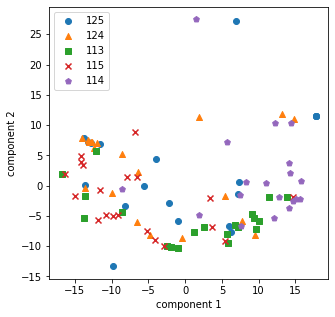

In [50]:
fig = plt.figure(figsize=(5,5))
#ax = fig.gca(projection='3d')
for i, marker in enumerate(markers) :
    x_axis = x_pca[x_pca['target']==i][0]
    y_axis = x_pca[x_pca['target']==i][1]
    
    plt.scatter(x_axis,y_axis, marker=marker, label = name[i])

plt.legend(loc='upper left')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

In [51]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda= LinearDiscriminantAnalysis(n_components =2)
#scaler = StandardScaler()
#x_scaled = scaler.fit_transform(x)
lda.fit(x_scaled,y)
x_lda = lda.transform(x_scaled)
x_lda = pd.DataFrame(x_lda)
x_lda['target'] = y

/home/caijb/anaconda3/envs/pytts/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [52]:
#import sklearn.externals import joblib
#save_model = joblib.dump(lda,'lda.pkl')

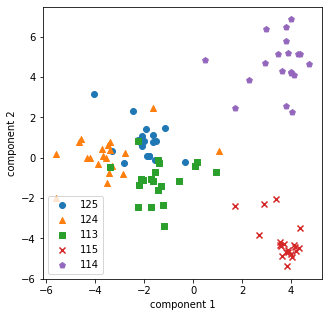

In [53]:
fig = plt.figure(figsize=(5,5))
#ax = fig.gca(projection='3d')
for i, marker in enumerate(markers) :
    x_axis = x_lda[x_lda['target']==i][0]
    y_axis = x_lda[x_lda['target']==i][1]
    plt.scatter(x_axis,y_axis, marker=marker, label = name[i])

plt.legend(loc='lower left')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()